In [1]:
%reset -f

In [2]:
import torch
import os
from pyDOE import lhs
from utils import torchIWT
import numpy as np
import scipy.io as sio
import torch.nn as nn
from torch.autograd import Variable
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
seed = 2947
# seed = 0
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
def exact_u(x):
    return x[:, [1]] * np.cos(5 * np.pi * x[:, [0]]) + np.power(x[:, [1]] * x[:, [0]], 3)

In [5]:
def x_f_loss_fun(x, train_U):
    k = 3
    a = -1
    b = 0
    c = 1

    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    u = train_U(x)
    d = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)
    u_t = d[0][:, 0].unsqueeze(-1)
    u_x = d[0][:, 1].unsqueeze(-1)
    u_tt = torch.autograd.grad(u_t, x, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, [0]]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, [1]]
    t = x[:, [0]]
    x1 = x[:, [1]]

    u_tt_tmp = - 25 * torch.pi ** 2 * x1 * torch.cos(5 * torch.pi * t) + 6 * t * x1 ** 3
    u_xx_tmp = 6 * x1 * t ** 3
    pde_u_tmp = x1 * torch.cos(5 * torch.pi * t) + (x1 * t) ** 3
    
    f = u_tt + a * u_xx + b * u + c * u ** k - (
        u_tt_tmp + a * u_xx_tmp + b * pde_u_tmp + c * pde_u_tmp ** k
    )
    
    return f

In [6]:
def get_kg_data(exact_u):
    x = np.expand_dims(np.linspace(0, 1, 100), axis=1)
    t = np.expand_dims(np.linspace(0, 1, 100), axis=1)
    X, T = np.meshgrid(x, t)
    x_test_np = np.concatenate(
        (np.vstack(np.expand_dims(X, axis=2)), 
         np.vstack(np.expand_dims(T, axis=2))), axis=-1)
    usol = exact_u(x_test_np)
    x = torch.from_numpy(x).float().to(device)
    t = torch.from_numpy(t).float().to(device)
    x_test = torch.from_numpy(x_test_np).float().to(device)
    x_test_exact = torch.from_numpy(usol).float().to(device)
    return x, t, x_test, x_test_exact

In [7]:
def get_pinn_input_data(Nic, Nbc):
    x_init = torch.from_numpy(np.expand_dims(np.linspace(0, 1, 100), axis=1)).float()
    x_init_point = torch.cat((torch.zeros(Nic, 1), x_init), dim=1)
    x_boundary_left_point = torch.cat((torch.rand([Nbc, 1]), torch.full([Nbc, 1], 0)), dim=1)
    x_boundary_right_point = torch.cat((torch.rand([Nbc, 1]), torch.ones([Nbc, 1])), dim=1)

    
    x_init_label = torch.from_numpy(exact_u(x_init_point.numpy())).float()
    x_boundary_left_label = torch.from_numpy(exact_u(x_boundary_left_point.numpy())).float()
    x_boundary_right_label = torch.from_numpy(exact_u(x_boundary_right_point.numpy())).float()

    x_boundary_point = torch.cat((x_boundary_left_point, x_boundary_right_point), dim=0)
    x_boundary_label = torch.cat((x_boundary_left_label, x_boundary_right_label), dim=0)

    x_ic = x_init_point.to(device)
    u_ic = x_init_label.to(device)
    x_bc = x_boundary_point.to(device)
    u_bc = x_boundary_label.to(device)
    
    return x_ic, u_ic, x_bc, u_bc

In [8]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)
    def forward(self, x):
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [9]:
class Model:
    def __init__(self, net, epoch,
                 lb, ub,
                 x_ic, u_ic, x_bc, u_bc,
                 x, t,
                 x_f_loss_fun,
                 x_test_point, x_test_exact):
        self.net = net
        self.epoch = epoch
        self.lb = lb
        self.ub = ub

        self.x_ic = x_ic
        self.u_ic = u_ic
        self.x_bc = x_bc
        self.u_bc = u_bc

        self.x = x
        self.t = t

        self.x_f = None

        self.x_f_loss_fun = x_f_loss_fun
        self.x_test_point = x_test_point
        self.x_test_exact = x_test_exact

        self.sample_N = 2000
        self.sample_M = 1000

        self.x_f_N = None
        self.x_f_M = None

        self.x_ic_s = torch.tensor(0.).float().to(device)
        self.x_bc_s = torch.tensor(0.).float().to(device)
        self.x_f_s = torch.tensor(0.).float().to(device)
        self.x_ict_s = torch.tensor(0.).float().to(device)

        self.x_test_estimate_collect = []

        self.top1 = torch.inf


    def true_loss(self, loss_e, loss_ic, loss_bc, loss_u0t):
        return torch.exp(-self.x_f_s.detach()) * loss_e \
            + torch.exp(-self.x_ic_s.detach()) * loss_ic \
            + torch.exp(-self.x_bc_s.detach()) * loss_bc \
            + torch.exp(-self.x_ict_s.detach()) * loss_u0t
    

    def likelihood_loss(self, loss_e, loss_ic, loss_bc, loss_u0t):
        loss = torch.exp(-self.x_f_s) * loss_e.detach() + self.x_f_s \
               + torch.exp(-self.x_ic_s) * loss_ic.detach() + self.x_ic_s \
               + torch.exp(-self.x_bc_s) * loss_bc.detach() + self.x_bc_s \
               + torch.exp(-self.x_ict_s) * loss_u0t.detach() + self.x_ict_s
        return loss
    

    def evaluate(self):
        pred = self.net(self.x_test_point).cpu().detach().numpy()
        exact = self.x_test_exact.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error
    

    def random_sample(self, num):
        temp = torch.from_numpy(self.lb + (self.ub - self.lb) * lhs(2, num)).float().to(device)
        return temp

    def run(self, lr, wlr, j0, J_tmp, e_tmp):

        optim = torch.optim.Adam(self.net.parameters(), lr)
        optim_weight = torch.optim.Adam([self.x_f_s] + [self.x_ic_s] + [self.x_bc_s] + [self.x_ict_s], lr=wlr)
        optim2 = torch.optim.LBFGS(self.net.parameters(), lr=1.0,
            max_iter=50000, max_eval=50000, history_size=50,
            tolerance_grad=1e-7, tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )

        for i in range(self.epoch):
            optim.zero_grad()

            f_pred = self.x_f_loss_fun(self.x_f, self.net)
            loss_e = torch.mean(f_pred ** 2)

            u_bc_pred = self.net(self.x_bc)
            loss_bc = torch.mean((u_bc_pred - self.u_bc) ** 2)

            u_ic_pred = self.net(self.x_ic)
            loss_ic = torch.mean((u_ic_pred - self.u_ic) ** 2)

            x_tmp = Variable(self.x_ic, requires_grad=True)
            u0 = self.net(x_tmp)
            d = torch.autograd.grad(u0, x_tmp, grad_outputs=torch.ones_like(u0), create_graph=True)
            u0_t = d[0][:, 0].unsqueeze(-1)
            loss_u0t = torch.mean(u0_t ** 2)

            loss = self.true_loss(loss_e, loss_ic, loss_bc, loss_u0t)
            if ((i+1) % 2500) == 0 and (i != 0):
                self.move_point(j0, J_tmp, e_tmp)
            print('network train epoch: {}, loss: {}'.format(i, loss.item()), end='\r')

            loss.backward()
            optim.step()            
            optim_weight.zero_grad()
            loss = self.likelihood_loss(loss_e, loss_ic, loss_bc, loss_u0t)
            loss.backward()
            optim_weight.step()
        print("\nOPTIM1 DONE")


        closure_i = 0
        def closure():
            optim2.zero_grad()
            f_pred = self.x_f_loss_fun(self.x_f, self.net)
            loss_e = torch.mean(f_pred ** 2)

            u_bc_pred = self.net(self.x_bc)
            loss_bc = torch.mean((u_bc_pred - self.u_bc) ** 2)

            u_ic_pred = self.net(self.x_ic)
            loss_ic = torch.mean((u_ic_pred - self.u_ic) ** 2)

            x_tmp = Variable(self.x_ic, requires_grad=True)
            u0 = self.net(x_tmp)
            d = torch.autograd.grad(u0, x_tmp, grad_outputs=torch.ones_like(u0), create_graph=True)
            u0_t = d[0][:, 0].unsqueeze(-1)
            loss_u0t = torch.mean(u0_t ** 2)

            loss = self.true_loss(loss_e, loss_ic, loss_bc, loss_u0t)

            loss.backward()
            nonlocal closure_i
            closure_i += 1
            # if closure_i % 2500 == 0:
            #     self.move_point(j0, J_tmp, e_tmp)
            print('network train epoch: {}, OPTIM2 LOSS:{}'.format(closure_i, loss.item()), end='\r')
            return loss
        
        optim2.step(closure)
        print("\nOPTIM2 DONE")
        error = self.evaluate()
        if error < self.top1:
            self.top1 = error
            torch.save(self.net.state_dict(), './best_model.pth')
        print('Test_L2error:', '{0:.2e}'.format(error))
        self.x_test_estimate_collect.append([error])
            
    def train(self, move_epoch, lr, wlr, j0, J, e):
        self.x_f_N = self.random_sample(self.sample_N)
        self.x_f_M = self.random_sample(self.sample_M)

        self.x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)

        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_bc_s = nn.Parameter(self.x_bc_s, requires_grad=True)
        self.x_ic_s = nn.Parameter(self.x_ic_s, requires_grad=True)
        self.x_ict_s = nn.Parameter(self.x_ict_s, requires_grad=True)
        
        self.run(lr[0], wlr, j0, J, e)

        for j in range(1, move_epoch):
            print("epoch: ", j)
            if j > 4:
                lr_tmp = lr[-1]
            else:
                lr_tmp = lr[j]
            self.run(lr_tmp, wlr, j0, J, e) 
    
    def move_point(self, j0, J_tmp, e_tmp):
        imgl = self.net(self.x_test_point).reshape(self.x.shape[0], self.t.shape[0])
        iwt = torchIWT(j0, J_tmp, e_tmp).to(device)

        _, idxs = iwt.get_Iwt2d(imgl, self.x, self.t)
        idxn = []
        for i in idxs:
            idxn = idxn + i
        idxn = torch.tensor(idxn).to(device).float()

        kde = gaussian_kde(idxn.cpu().T)
        expanded_idxns = kde.resample(self.sample_M).T
        expanded_idxns = torch.tensor(expanded_idxns).float().to(device)
        k = torch.cat((idxn, expanded_idxns), dim=0)

        k[:,0] = k[:, 0] / self.x.shape[0] # x 0-1
        k[:,1] = k[:, 1] / self.t.shape[0]  # t

        k2 = k[(k[:, 0] >= self.lb[1]) & (k[:, 0] <= self.ub[1]) & (k[:, 1] >= self.lb[0]) & (k[:, 1] < self.ub[0])]
        k = torch.unique(k2, dim=0)

        self.x_f_M = torch.zeros_like(k)
        self.x_f_M[:, 0] = k[:, 1]
        self.x_f_M[:, 1] = k[:, 0]

        self.x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        
        print("\nnumber of moved point:{}".format(self.x_f_M.shape[0]))

In [10]:
Nic = 100
Nbc = 100
x_ic, u_ic, x_bc, u_bc = get_pinn_input_data(Nic, Nbc)
x, t, x_test_point, x_test_exact = get_kg_data(exact_u)

In [11]:
layers = [2, 20, 20, 20, 20, 1]
epoch = 5000

lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])
net = Net(layers).to(device)

model = Model(net, epoch,
                lb, ub,
                x_ic, u_ic, x_bc, u_bc,
                x, t,
                x_f_loss_fun,
                x_test_point, x_test_exact)

lr = [0.001, 0.001, 0.0003, 0.0001, 0.00003]
wlr = 0.001

j0 = 0
J = 5
e = 0.03

model.train(move_epoch=10, lr=lr, wlr=wlr, j0=j0, J=J, e=e)  # 10

network train epoch: 2498, loss: 6.2974295616149965
number of moved point:1241
network train epoch: 4998, loss: 2.9251246452331543
number of moved point:1266
network train epoch: 4999, loss: 2.924942970275879
OPTIM1 DONE
network train epoch: 8270, OPTIM2 LOSS:0.0019847673829644924
OPTIM2 DONE
Test_L2error: 3.08e-02
epoch:  1
network train epoch: 2498, loss: 0.0095821572467684755
number of moved point:1307
network train epoch: 4998, loss: 0.046329770237207414
number of moved point:1304
network train epoch: 4999, loss: 0.04635664075613022
OPTIM1 DONE
network train epoch: 5142, OPTIM2 LOSS:0.0021109799854457387
OPTIM2 DONE
Test_L2error: 1.39e-03
epoch:  2
network train epoch: 2498, loss: 0.0081429947167634964
number of moved point:1321
network train epoch: 4998, loss: 0.019060712307691574
number of moved point:1286
network train epoch: 4999, loss: 0.019043589010834694
OPTIM1 DONE
network train epoch: 11, OPTIM2 LOSS:0.019410520792007446
OPTIM2 DONE
Test_L2error: 1.37e-03
epoch:  3
network

In [12]:
x_test_pred = net(x_test_point)

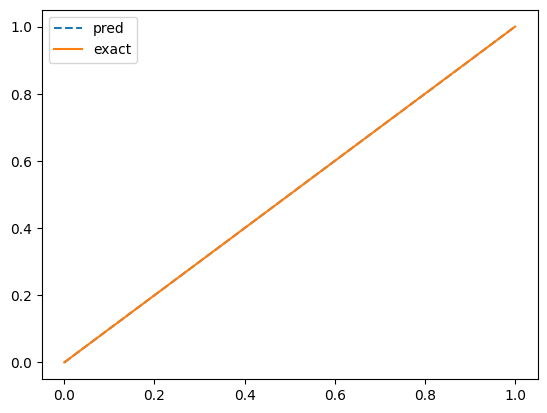

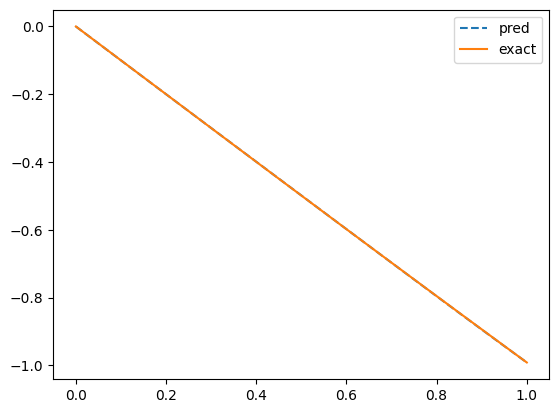

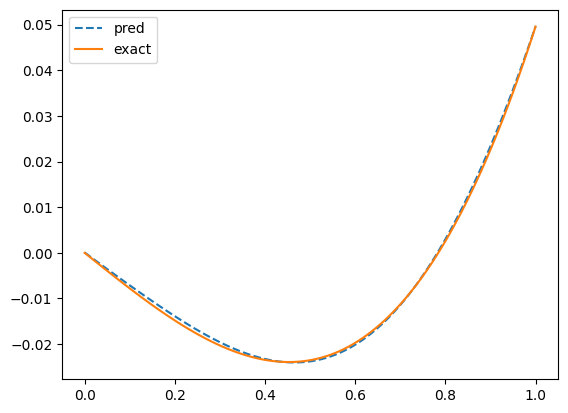

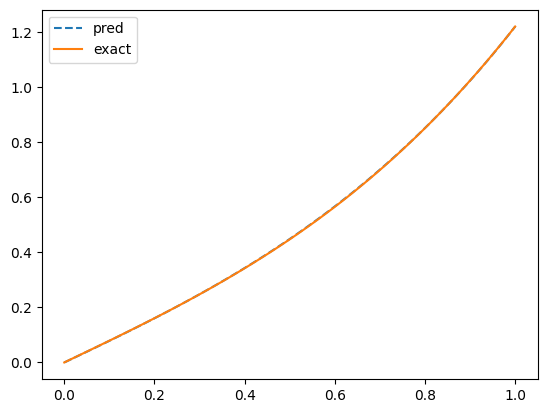

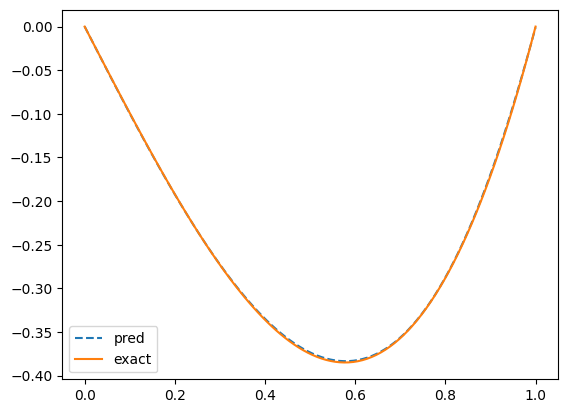

In [13]:
x_test_pred = net(x_test_point)
x_test_pred = x_test_pred.reshape(x.shape[0], t.shape[0])
x_test_pred = x_test_pred.to('cpu').detach().numpy()
x_test_exact = x_test_exact.reshape(x.shape[0], t.shape[0])
x_test_exact = x_test_exact.to('cpu').detach().numpy()
x1 = x.cpu().detach().numpy()
t1 = t.cpu().detach().numpy()
plt.figure()
plt.plot(x1, x_test_pred[:, 0], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, 0], label='exact')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[:, 25], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, 25], label='exact')
plt.ylim([-1.0, 0.1])
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[:, 50], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, 50], label='exact')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[:, -1], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, -1], label='exact')
plt.ylim([-1.0, 0.1])
plt.legend()

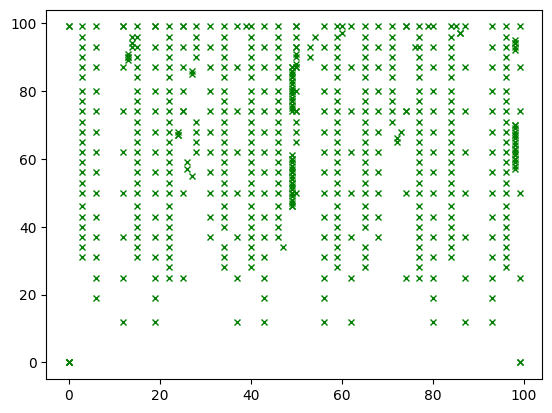

In [14]:
imgl = model.net(model.x_test_point).reshape(model.x.shape[0], model.t.shape[0])

iwt = torchIWT(j0, 7, 0.03).to(device)

_, idxs = iwt.get_Iwt2d(imgl, model.x, model.t)
idxn = []
for i in idxs:
    idxn = idxn + i
idxn = torch.tensor(idxn).to(device).float()
plt.plot(idxn[:, [1]].cpu().numpy(), idxn[:, [0]].cpu().numpy(), 'gx', markersize=4)